In [362]:
import numpy as np
import pandas as pd
import scipy
import imageio
import math
import phylo

from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set(style="ticks")
plt.style.use("seaborn-whitegrid")

In [2]:
%load_ext blackcellmagic

In [3]:
np.random.seed(820)
REGULAR_POKEMON = phylo.vectorize_pokemon(phylo.REGULAR_POKEMON_PATH)
SHINY_POKEMON = phylo.vectorize_pokemon(phylo.SHINY_POKEMON_PATH)

Vectorizing pokemon from /Users/vineshkannan/Documents/GitHub/phylo/images/regular/
Vector iteration 0
Vector iteration 100
Vector iteration 200
Vector iteration 300
Vector iteration 400
Vector iteration 500
Vector iteration 600
Done vectorizing
Vectorizing pokemon from /Users/vineshkannan/Documents/GitHub/phylo/images/shiny/
Vector iteration 0
Vector iteration 100
Vector iteration 200
Vector iteration 300
Vector iteration 400
Vector iteration 500
Vector iteration 600
Done vectorizing


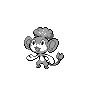

In [4]:
known_creatures = list(REGULAR_POKEMON) + list(SHINY_POKEMON)
np.random.shuffle(known_creatures)
phylo.unvectorize(known_creatures[0])

In [409]:
def col_counts(col):
    buckets = np.zeros(phylo.Q + 1)
    for x in col:
        buckets[x] += 1
    return buckets

def col_freq(col):
    buckets = col_counts(col)
    freq = buckets / buckets.sum()
    return freq

def col_exp(col):
    freq = col_freq(col)
    expt = np.dot(freq, np.array(range(phylo.Q + 1))).sum()
    return expt

def draw_val(col):
    expt = col_exp(col)
    return math.floor(expt)

def generate_expected(train_pop, n_sub, seed=None):
    if seed:
        np.random.seed(seed)
    idxs = list(np.random.choice(range(len(train_pop)), n_sub))
    subsample = np.array([train_pop[i] for i in idxs])
    ev = np.array([draw_val(subsample[:,j]) for j in range(phylo.M**2)])
    return ev

def expect_from_subsample(subsample):
    ev = np.array([draw_val(subsample[:,j]) for j in range(phylo.M**2)])
    return ev

In [55]:
n_sub = 50
train_pop = known_creatures + [phylo.generate_random() for i in range(len(known_creatures))]
np.random.shuffle(train_pop)
len(train_pop)

2596

In [62]:
N = 200
xidxs = np.random.choice(range(len(known_creatures)), N)
X = [known_creatures[i] for i in xidxs]
for i in range(N):
    ev = generate_expected(train_pop, n_sub)
    X.append(ev)
    if i % 10 == 0:
        print("Generated {}".format(i))
y = [True for i in range(N)] + [False for i in range(N)]
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1./3, random_state=820)

Generated 0
Generated 10
Generated 20
Generated 30
Generated 40
Generated 50
Generated 60
Generated 70
Generated 80
Generated 90
Generated 100
Generated 110
Generated 120
Generated 130
Generated 140
Generated 150
Generated 160
Generated 170
Generated 180
Generated 190


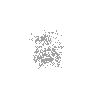

In [65]:
phylo.unvectorize(X_train[0])

In [94]:
clf = LogisticRegression(
    random_state=0, solver="liblinear", multi_class="ovr", max_iter=200
).fit(X_train, y_train)
print("Mean Train Accuracy = {0:.3f}".format(clf.score(X_train, y_train)))
print("Mean Test Accuracy = {0:.3f}".format(clf.score(X_test, y_test)))
print(clf.classes_)
w = clf.coef_
w

Mean Train Accuracy = 1.000
Mean Test Accuracy = 0.933
[False  True]


array([[-0.00597215, -0.00384264, -0.00421947, ..., -0.01168732,
        -0.00681694, -0.00120973]])

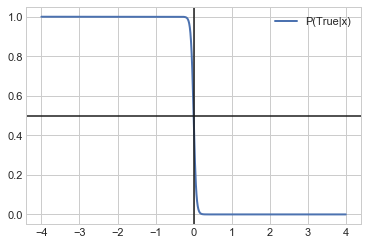

In [104]:
def lf(s):   
    return 1./(1 + np.exp(s))

pf = lf
pt = lambda x: 1-pf(x)

xs = np.linspace(-4, 4, 1000)
_, ax = plt.subplots()
ax.plot(xs, [pt(np.dot(x, w).sum()) for x in xs], linewidth=2, label='P(True|x)')
ax.axhline(y=0.5, color='k')
ax.axvline(x=0, color='k')
ax.legend()

P(F) = 0.001 P(T) = 0.999


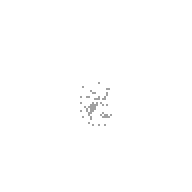

In [105]:
ev = generate_expected(X_test, n_sub)
print("P(F) = {0:.3f} P(T) = {1:.3f}".format(*clf.predict_proba([ev])[0]))
phylo.scale_img(phylo.unvectorize(ev), 2)

P(F) = 0.690 P(T) = 0.310


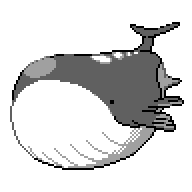

In [183]:
tv = X_test[0]
print("P(F) = {0:.3f} P(T) = {1:.3f}".format(*clf.predict_proba([tv])[0]))
phylo.scale_img(phylo.unvectorize(tv), 2)

In [136]:
actual_f = []
for i, target in enumerate(y_test):
    if not target:
        xv = X_test[i]
        actual_f.append(xv)
vdf = pd.DataFrame()
vdf["x"] = actual_f
vdf["pt"] = clf.predict_proba(np.array(actual_f))[:,1]
sdf = vdf.sort_values(by="pt", ascending=False)
sdf.head(5)

,x,pt
52,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.724441
39,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.408736
22,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ...",0.265730
56,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.242465
29,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.187792


P(True) = 0.409


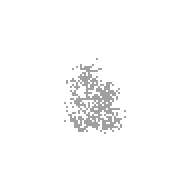

In [137]:
idx = 39
print("P(True) = {0:.3f}".format(vdf["pt"][idx]))
phylo.scale_img(phylo.unvectorize(vdf["x"][idx]), 2)

In [155]:
t_cases = []
f_cases = []
for i, target in enumerate(y_train):
    if target:
        t_cases.append(X_train[i])
    else:
        f_cases.append(X_train[i])

In [175]:
def active_prop(xv):
    max_active = phylo.M**2
    active = sum(map(lambda x: 1 if x > 1 else 0, xv))
    return active / max_active

def centrality(xv):
    w_sum = 0
    cx = math.floor(phylo.M / 2)
    cy = cx
    for i in range(len(xv)):
        q = xv[i]
        y = math.floor(i / phylo.M)
        x = i % phylo.M
        sy = 1.0 - ((y - cy) / cy)
        sx = 1.0 - ((x - cx) / cx)
        v = q * sx * sy
        w_sum += v
    return w_sum

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


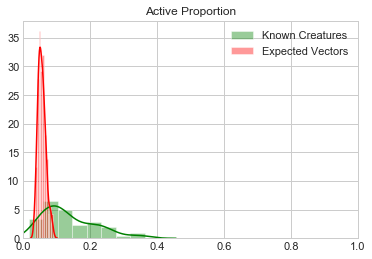

In [402]:
taps = [active_prop(x) for x in t_cases]
faps = [active_prop(x) for x in f_cases]
sns.distplot(taps, color="green", label="Known Creatures")
sns.distplot(faps, color="red", label="Expected Vectors")
plt.xlim(0, 1)
plt.title("Active Proportion")
plt.legend()

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


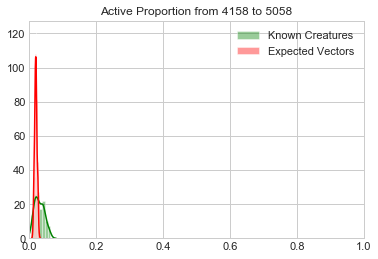

In [401]:
mid = math.floor(phylo.M**2 / 2)
mx = math.floor(30**2 / 2)
taps = [active_prop(x[mid-mx:mid+mx]) for x in t_cases]
faps = [active_prop(x[mid-mx:mid+mx]) for x in f_cases]
sns.distplot(taps, color="green", label="Known Creatures")
sns.distplot(faps, color="red", label="Expected Vectors")
plt.xlim(0, 1)
plt.title("Active Proportion from {} to {}".format(mid-mx, mid+mx))
plt.legend()

P(False) = 0.039 P(True) = 0.961


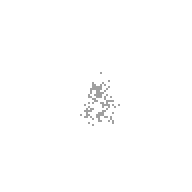

In [405]:
ev1 = generate_expected(X_test, n_sub, seed=40)
print("P(False) = {0:.3f} P(True) = {1:.3f}".format(*clf.predict_proba([ev1])[0]))
phylo.scale_img(phylo.unvectorize(ev1), 2)

P(False) = 0.003 P(True) = 0.997


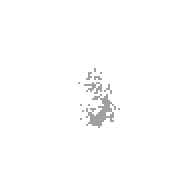

In [403]:
ev2 = generate_expected(X_test, n_sub, seed=93)
print("P(False) = {0:.3f} P(True) = {1:.3f}".format(*clf.predict_proba([ev2])[0]))
phylo.scale_img(phylo.unvectorize(ev2), 2)

P(False) = 0.563 P(True) = 0.437


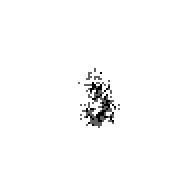

In [404]:
ev3 = np.array(list(map(lambda x: x if x > 2 else 0, ev1 + ev2)))
print("P(False) = {0:.3f} P(True) = {1:.3f}".format(*clf.predict_proba([ev3])[0]))
phylo.scale_img(phylo.unvectorize(ev3), 2)

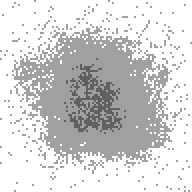

In [215]:
ev_fp = vdf["x"][idx]
phylo.scale_img(phylo.unvectorize(map(lambda x: x + 1,ev_fp)), 2)

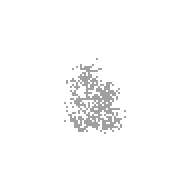

In [242]:
phylo.scale_img(phylo.unvectorize(ev_fp), 2)

In [429]:
def show_trans(im):
    background = (238, 255, 188, 255)
    pixels = np.array(im).reshape(phylo.M * phylo.M, phylo.C)
    new_pix = [background if p[-1] == phylo.TRANSPARENT else p for p in pixels]
    new_pix = np.array(np.uint8(new_pix)).reshape(phylo.M, phylo.M, phylo.C)
    return Image.fromarray(new_pix, mode=phylo.MODE)
    
def in_im(x, y):
    return x >= 0 and x < phylo.M and y >= 0 and y < phylo.M

def neighbors4(x, y, r=1):
    neigh = [(x - r, y), (x + r, y), (x, y - r), (x, y + r)]
    neigh = list(filter(lambda t: in_im(*t), neigh))
    return neigh

def clean_fluff(xv):
    r = 4
    mat = xv.reshape(phylo.M, phylo.M)
    out = np.uint8(np.zeros(phylo.M**2).reshape(phylo.M, phylo.M))
    for y, row in enumerate(mat):
        for x, cell in enumerate(row):
            neigh = neighbors4(x, y, r)
            n_vals = [mat[yn][xn] for xn, yn in neigh]
            out[y][x] = cell
            if max(n_vals) <= 1:
                out[y][x] = 0
    return out.reshape(phylo.M**2)

def add_border(xv):
    r = 4
    mat = xv.reshape(phylo.M, phylo.M)
    out = np.uint8(np.zeros(phylo.M**2).reshape(phylo.M, phylo.M))
    for y, row in enumerate(mat):
        for x, cell in enumerate(row):
            neigh = neighbors4(x, y, r)
            n_vals = [mat[yn][xn] for xn, yn in neigh]
            out[y][x] = cell
            if max(n_vals) <= 1:
                out[y][x] = 0
            if max(n_vals) == 2 and cell <= 1 and sum(n_vals) < 6:
                out[y][x] = phylo.Q
    return out.reshape(phylo.M**2)

def neigh_map(xv):
    r = 1
    mat = xv.reshape(phylo.M, phylo.M)
    out = np.uint8(np.zeros(phylo.M**2).reshape(phylo.M, phylo.M))
    for y, row in enumerate(mat):
        for x, cell in enumerate(row):
            neigh = neighbors4(x, y, r)
            n_vals = [mat[yn][xn] for xn, yn in neigh]
            out[y][x] = max(n_vals)
    return out.reshape(phylo.M**2)

def easy_show(xv, scale=1, border=False):
    vec = xv
    if border:
        vec = add_border(xv)
    return phylo.scale_img(show_trans(phylo.unvectorize(vec)), scale)

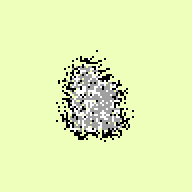

In [387]:
ev_bord = add_border(ev_fp)
phylo.scale_img(show_trans(phylo.unvectorize(ev_bord)), 2)

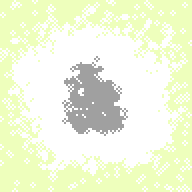

In [388]:
phylo.scale_img(show_trans(phylo.unvectorize((neigh_map(ev_fp)))), 2)

In [389]:
false_pos = []
for i in range(50):
    if i % 10 == 0:
        print(i)
    ev = generate_expected(X_test, 50)
    if clf.predict([ev])[0]:
        false_pos.append(ev)
print("Done.")

0
10
20
30
40
Done.


50


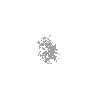

In [359]:
print(len(false_pos))
phylo.unvectorize(false_pos[0])

In [380]:
for zoot in false_pos:
    phylo.scale_img(show_trans(phylo.unvectorize(add_border(zoot))), 2).show()

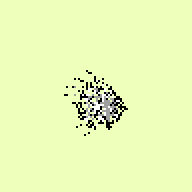

In [379]:
phylo.scale_img(show_trans(phylo.unvectorize(add_border(false_pos[-1]))), 2)

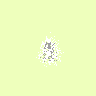

In [390]:
show_trans(phylo.unvectorize(clean_fluff(ev1)))

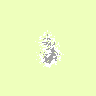

In [391]:
show_trans(phylo.unvectorize(clean_fluff(ev2)))

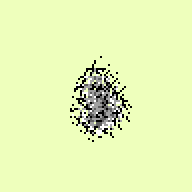

In [399]:
easy_show(add_border(clean_fluff(ev1) + clean_fluff(ev2)), 2)

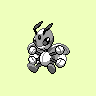

In [421]:
easy_show(X_test[4])

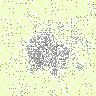

In [422]:
rsv = [phylo.generate_random() for i in range(5)]
esv = expect_from_subsample(np.array([X_test[3], X_test[4], *rsv]))
easy_show(clean_fluff(esv))

In [423]:
col_counts(X_test[4])

array([7880.,  257.,  387.,  353.,  339.])

In [424]:
col_counts(rsv[0])

array([1834., 1827., 1836., 1844., 1875.])

In [444]:
def make_border_hist(i, X, y):
    if not y[i]:
        return col_counts(add_border(X[i]))
    else:
        return col_counts(X[i])
    
X_hist_train = np.array([make_border_hist(i, X_train, y_train) for i in range(len(X_train))])
X_hist_test = np.array([make_border_hist(i, X_test, y_test) for i in range(len(X_test))])

In [449]:
hist_model = LogisticRegression(
    random_state=0, solver="lbfgs", multi_class="multinomial", max_iter=200
).fit(X_hist_train, y_train)
print("Mean Train Accuracy = {0:.3f}".format(hist_model.score(X_hist_train, y_train)))
print("Mean Test Accuracy = {0:.3f}".format(hist_model.score(X_hist_test, y_test)))
print(hist_model.classes_)

Mean Train Accuracy = 1.000
Mean Test Accuracy = 0.993
[False  True]


In [450]:
hist_model.coef_

array([[ 0.00032299, -0.00203453, -0.00280481,  0.0932072 , -0.02334179]])

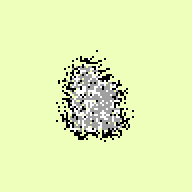

In [451]:
easy_show(ev_fp, border=True, scale=2)

In [452]:
hist_model.predict_proba([col_counts(ev_fp)])

array([[9.99996681e-01, 3.31886991e-06]])

In [477]:
hist_fps = []
hist_pred = hist_model.predict(X_hist_test)
for i, hp in enumerate(hist_pred):
    if hp and (not y_test[i]) or (not hp and (y_test[i])):
        hist_fps.append((i, X_hist_test[i], y_test[i]))
len(hist_fps)

1

In [478]:
hist_fps[0]

(15, array([7369.,  159.,  292.,   60., 1336.]), True)

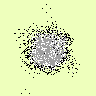

In [481]:
easy_show(X_train[hist_fps[0][0]], border=True)

In [488]:
nevs = [generate_expected(train_pop, n_sub) for i in range(10)]
nevs

[array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 1, 1, 1]),
 array([0, 1, 0, ..., 0, 0, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 0, ..., 1, 1, 1]),
 array([0, 1, 0, ..., 1, 0, 0]),
 array([1, 1, 1, ..., 1, 0, 1]),
 array([0, 0, 0, ..., 1, 0, 0]),
 array([0, 1, 0, ..., 1, 0, 0]),
 array([1, 1, 1, ..., 1, 1, 1])]

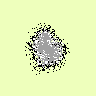

In [490]:
easy_show(nevs[0], border=True)

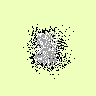

In [493]:
easy_show(nevs[3], border=True)

In [494]:
hist_model.predict([col_counts(add_border(nv)) for nv in nevs])

array([False, False, False, False, False, False, False, False, False,
       False])